## Importing the libraries and seting the paths

In [676]:
from utils import open_nea_table, download_nea_table
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

from sklearn.neighbors import KernelDensity
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mr_utils import creating_MR_ML_table, creating_R_ML_table, MR_plot
from mr_ml_utils import RF_training_with_display, RF_training


from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Displaying and analysing the data

In [677]:
#If needed to update the NEA table then first run  "download_nea_table"
#download_nea_table()
nea_full_table = open_nea_table()
# Creating the final table with R, M, and Teq.
MR_ML_table_init = creating_MR_ML_table(nea_full_table)

# Selecting only planets with masses above 1 Mearh (there are very few such planets)
# and below 13 Jup (~4000 Mearth) corresponding to Brown Dwarf mass
MR_ML_table = MR_ML_table_init[(MR_ML_table_init.pl_bmasse > 0.1) & (MR_ML_table_init.pl_bmasse < 40000)]


MR_ML_table['pl_bmasse_log'] = np.log10(MR_ML_table['pl_bmasse'])

/home/vadibekyan/my_github/ExoCodes/utils.py:52: DtypeWarning:

Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.

/home/vadibekyan/my_github/ExoCodes/mr_utils.py:261: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



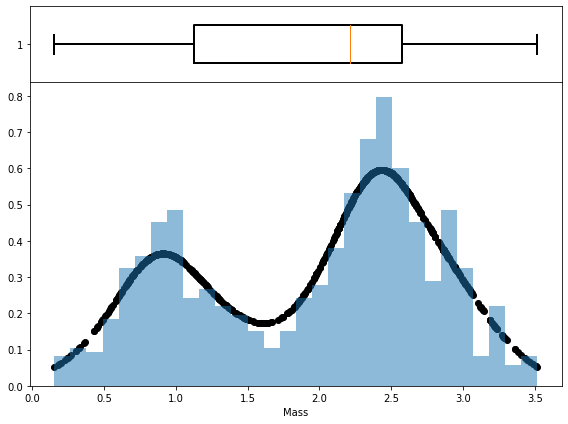

In [678]:
# Perform kernel density estimation (KDE) on the 'parameter' column
kde = KernelDensity(bandwidth=0.2).fit(MR_ML_table['pl_bmasse_log'].values.reshape(-1, 1))
# Calculate the density of each value in the 'parameter' column
densities = np.exp(kde.score_samples(MR_ML_table['pl_bmasse_log'].values.reshape(-1, 1)))

# Create the figure and gridspec for customizing subplot sizes
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 4], hspace=0)

# Define the upper and lower subplots using gridspec
ax_boxplot = fig.add_subplot(gs[0])
ax_histogram = fig.add_subplot(gs[1])

# Plot the boxplot in the top subplot
boxplot_dict = ax_boxplot.boxplot(MR_ML_table['pl_bmasse_log'], vert=False, showfliers=True, widths=0.5)
# Hide x-axis labels of the top subplot
ax_boxplot.xaxis.set_ticklabels([])

# Adjust the line width of the boxplot elements
for element in ['boxes', 'whiskers', 'caps']:
    plt.setp(boxplot_dict[element], linewidth=2)  # Adjust the linewidth here


# Extract the outliers from the boxplot dictionary
outliers = boxplot_dict['fliers'][0].get_data()

# Plot the histogram in the bottom subplot
ax_histogram.hist(MR_ML_table['pl_bmasse_log'], bins=30, density = True, alpha = 0.5)
ax_histogram.scatter(MR_ML_table['pl_bmasse_log'], densities, color = 'black')

# Add labels and adjust layout
plt.xlabel('Mass')
plt.tight_layout()


In [679]:
MR_ML_train, MR_ML_test = train_test_split(MR_ML_table, test_size = 0.25)

In [680]:
# This method is apparently similar to the one presented in https://github.com/YyzHarry/imbalanced-regression  https://arxiv.org/pdf/2102.09554.pdf
def ballancing(dataframe, target_column, kde_bandwidth):
    from sklearn.neighbors import KernelDensity

    # Perform kernel density estimation (KDE) on the 'parameter' column
    kde = KernelDensity(bandwidth=kde_bandwidth).fit(dataframe[target_column].values.reshape(-1, 1))

    # Calculate the density of each value in the 'target_column' column
    densities = np.exp(kde.score_samples(dataframe[target_column].values.reshape(-1, 1)))

    # Calculate the number of times each data point should be duplicated
    num_duplicates = (densities.max()/densities).astype(int)

    # Create a new DataFrame to store the oversampled data
    oversampled_df = pd.DataFrame(columns=dataframe.columns)

    # Oversample the underrepresented regions
    for i, row in dataframe.iterrows():
        num_duplicates[i] = min(num_duplicates[i], 1)
        duplicated_points = [row] * num_duplicates[i]
        duplicated_points_df = pd.DataFrame(duplicated_points)
        oversampled_df = pd.concat([oversampled_df, duplicated_points_df], axis=0, ignore_index=True)

    #print (f'Original sample = {len(dataframe)}, balanced sample = {len(oversampled_df)} ')

    return oversampled_df

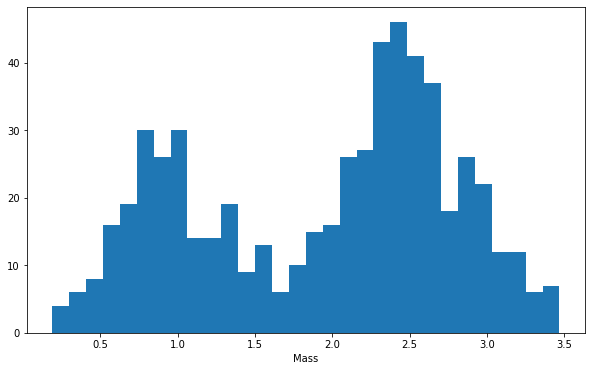

In [681]:
df = MR_ML_train.copy().reset_index().drop(columns = ['index'])

oversampled_df = ballancing(df, 'pl_bmasse_log', 0.1)

fig = plt.figure(2, figsize = (10,6))
plt.hist(oversampled_df['pl_bmasse_log'], bins = 30)
plt.xlabel('Mass')
plt.show()

# Starting the Machine Learning part

Since the accuracy of Mass estimation is not critical, I'll make things simple (but still keeping the state-of-the-art): 

Use Random Forest regressor and tune HyperParameters with "optuna" (sometimes better than grid_search see e.g. [this](https://medium.com/mlearning-ai/hyper-parameter-tuning-through-grid-search-and-optuna-2bd89a2ece06)

In [682]:
R_ML_table = creating_R_ML_table(nea_full_table)


/home/vadibekyan/my_github/ExoCodes/mr_utils.py:319: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Testing hyperparameters for overfitting/underfitting

In [683]:
def modified_learning_curve(X_train, y_train, X_test, y_test, model, N, CV=5):
    """
    Calculate and plot the modified learning curve for a given model.

    Parameters:
        X_train (array-like): The input features of the training dataset.
        y_train (array-like): The target variable of the training dataset.
        X_test (array-like): The input features of the test dataset.
        y_test (array-like): The target variable of the test dataset.
        model: The machine learning model used for prediction.
        N (int): The number of data points to be used in the learning curve.
        CV (int): The number of cross-validation folds (default: 5).
    Returns:
        DataFrame: The learning curve results.

    """

    # Generate an array of training sizes
    train_sizes = np.linspace(0.05, 0.99, N)

    # Create an empty DataFrame to store the learning curve results
    results = pd.DataFrame(columns=['train_size', 'mae_train_mean', 'mae_train_std', 'mae_test_mean', 'mae_test_std'],
                           index=range(0, N))

    # Iterate over the training sizes
    for i, train_size in enumerate(train_sizes):
        mae_train = []
        mae_test = []

        # Repeat the cross-validation process for each training size
        for j in range(CV):
            # Split the training set into a subset based on the current training size
            X_train_tmp, _, y_train_tmp, _ = train_test_split(X_train, y_train, test_size=(1 - train_size))

            # Fit the model on the subset of training data
            model.fit(X_train_tmp, y_train_tmp)

            # Make predictions on the test set
            y_pred_test = model.predict(X_test)
            y_pred_train_tmp = model.predict(X_train_tmp)

            # Evaluate the model using mean absolute error
            mae_train.append(mean_squared_error(y_train_tmp, y_pred_train_tmp))
            mae_test.append(mean_squared_error(y_test, y_pred_test))

        # Store the learning curve results in the DataFrame
        results['train_size'][i] = len(X_train_tmp)
        results['mae_train_mean'][i] = np.mean(mae_train)
        results['mae_train_std'][i] = np.std(mae_train)
        results['mae_test_mean'][i] = np.mean(mae_test)
        results['mae_test_std'][i] = np.std(mae_test)


    # Convert object columns to numeric type in the DataFrame
    for column in results.columns:
        if results[column].dtype == 'object':
            results[column] = pd.to_numeric(results[column], errors='coerce')


    return results

In [684]:
def score_dataset(X, y, model, cv = 5):
    """
    Calculate the mean absolute error (MAE) score for a dataset using cross-validation.

    Parameters:
        X (array-like): The input features of the dataset.
        y (array-like): The target variable of the dataset.
        model: The machine learning model used for prediction.

    Returns:
        float: Mean absolute error score.

    """

    train_mae_list = []
    dev_mae_list = []

    for i in range(cv):
        X_train_tmp, X_dev, y_train_tmp, y_dev = train_test_split(X, y, test_size = 1/cv)

        # Oversampling the training data to balance it
        df = pd.concat([X_train_tmp, y_train_tmp], axis = 1).reset_index().drop(columns = ['index'])
        oversampled_df = ballancing(df, 'pl_bmasse_log', 0.1)

        X_train = oversampled_df.drop(columns = ['pl_bmasse_log'])
        y_train = oversampled_df['pl_bmasse_log']     

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        train_mae = mean_squared_error(y_train, y_train_predict)
        train_mae_list.append(train_mae)

        y_dev_predict = model.predict(X_dev)
        dev_mae = mean_squared_error(y_dev, y_dev_predict)
        dev_mae_list.append(dev_mae)        
        
    train_mae_mean = np.mean(train_mae_list)
    dev_mae_mean = np.mean(dev_mae_list)
    mae_mean = (2*dev_mae_mean + train_mae_mean)/2
   
    #print (train_mae_mean, dev_mae_mean, mae_mean)
    return train_mae_mean, dev_mae_mean, mae_mean


In [685]:
def optuna_SVR_new(X_train_dev, y_train_dev, n_trials,  display=False, mae_type = 'dev_mae'):
    """
    Perform hyperparameter optimization for Random Forest Regression using Optuna.

    Parameters:
        X_train (array-like): The input features of the training dataset.
        y_train (array-like): The target variable of the training dataset.
        n_trials (int): The number of optimization trials to perform.
        display (bool): Whether to display optimization visualizations (default: False).

    Returns:
        dict: The best hyperparameters found during optimization.

    """
    # Import necessary libraries and modules
    import optuna
    from optuna.visualization import plot_contour
    from optuna.visualization import plot_param_importances

    def objective(trial):
        """
        Objective function for Optuna optimization.
        Defines the hyperparameters to optimize and trains Random Forest Regression models with different hyperparameter configurations.

        Parameters:
            trial: An Optuna trial object.

        Returns:
            float: The score (negative mean absolute error) of the trained model.
        """
        # Define the hyperparameters to optimize using Optuna's suggest methods
        SVR_params = dict(
            #C=trial.suggest_float("C", 1e-3, 50, log = True),
            #epsilon=trial.suggest_float("epsilon", 0.01, 0.5),
            #gamma=trial.suggest_float("gamma", 1e-3, 1, log = True),
            #degree =  trial.suggest_int('degree', 2, 7),
        )

        # Train a Random Forest Regression model with the current hyperparameter configuration
        SVR_model = make_pipeline(StandardScaler(), SVR(**SVR_params)).fit(X_train_dev, y_train_dev)
        
        # Calculate the score (negative mean absolute error) using the score_dataset() function
        train_mae_mean, dev_mae_mean, mae_mean = score_dataset(X_train_dev, y_train_dev, SVR_model)
        if mae_type == 'mae_mean':
            return mae_mean
        if mae_type == 'dev_mae':
            return dev_mae_mean

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    SVR_best_params = study.best_params

    # Display optimization visualizations if display is True
    if display == True:
        plot_param_importances(study).show()
        plot_contour(study).show()

    # Print the best hyperparameters found during optimization
    print(f'\nThe best hyperparameters for SVR: {SVR_best_params}')

    # Return the best hyperparameters
    return SVR_best_params


In [686]:
def optuna_RF_Reg_new(X_train_dev, y_train_dev, n_trials,  display=False, mae_type = 'dev_mae'):
    """
    Perform hyperparameter optimization for Random Forest Regression using Optuna.

    Parameters:
        X_train (array-like): The input features of the training dataset.
        y_train (array-like): The target variable of the training dataset.
        n_trials (int): The number of optimization trials to perform.
        display (bool): Whether to display optimization visualizations (default: False).

    Returns:
        dict: The best hyperparameters found during optimization.

    """
    # Import necessary libraries and modules
    import optuna
    from optuna.visualization import plot_contour
    from optuna.visualization import plot_param_importances

    def objective(trial):
        """
        Objective function for Optuna optimization.
        Defines the hyperparameters to optimize and trains Random Forest Regression models with different hyperparameter configurations.

        Parameters:
            trial: An Optuna trial object.

        Returns:
            float: The score (negative mean absolute error) of the trained model.
        """
        # Define the hyperparameters to optimize using Optuna's suggest methods
        RF_reg_params = dict(
            n_estimators=trial.suggest_int("n_estimators", 40, 100, step=20),
            #max_depth=trial.suggest_int("max_depth", 3, 800),
            min_samples_split=trial.suggest_int("min_samples_split", 20, 50),
            #min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 6),
            #max_features=trial.suggest_int("max_features", 3, len(X_train_dev.columns)+1),
            random_state=0
        )

        # Train a Random Forest Regression model with the current hyperparameter configuration
        RF_reg = RandomForestRegressor(**RF_reg_params).fit(X_train_dev, y_train_dev)
        
        # Calculate the score (negative mean absolute error) using the score_dataset() function
        train_mae_mean, dev_mae_mean, mae_mean = score_dataset(X_train_dev, y_train_dev, RF_reg)
        if mae_type == 'mae_mean':
            return mae_mean
        if mae_type == 'dev_mae':
            return dev_mae_mean

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    RFR_best_params = study.best_params

    # Display optimization visualizations if display is True
    if display == True:
        plot_param_importances(study).show()
        plot_contour(study).show()

    # Print the best hyperparameters found during optimization
    print(f'\nThe best hyperparameters for RF Regressor: {RFR_best_params}')

    # Return the best hyperparameters
    return RFR_best_params


In [687]:
def SVR_training_with_display_new(X_train_dev, y_train_dev, n_trials=20, display=False, mae_type = 'dev_mae'):
    """
    Train a SVR model with hyperparameter optimization and display intermediate results.

    Parameters:
        X (array-like): The input features of the dataset.
        y (array-like): The target variable of the dataset.
        n_trials (int): The number of optimization trials to perform (default: 20).
        display (bool): Whether to display intermediate training results (default: False).

    Returns:
        tuple: The best model, final trained model on the training data, and final trained model on the full data.

    """

    # Create a base SV Regression model
    SVR_base_model = make_pipeline(StandardScaler(), SVR())

    # Calculate the base mean absolute error (MAE) score from the training set
    train_mae_mean, dev_mae_mean, mae_mean = score_dataset(X_train_dev, y_train_dev, SVR_base_model)

    # Print the base MAE scores
    print(f'The base MAE test =  {dev_mae_mean:.2f}; MAE train = {train_mae_mean:.2f}; MAE mean = {mae_mean:.2f}')

    # Perform hyperparameter optimization using Optuna and obtain the best hyperparameters
    SVR_best_params = optuna_SVR_new(X_train_dev, y_train_dev, n_trials, display=display, mae_type = mae_type)

    # Create the best model with the obtained hyperparameters
    best_model = make_pipeline(StandardScaler(), SVR(**SVR_best_params))

    # Train the final model on the training data using the best hyperparameters
    final_trained_model_train_data = best_model.fit(X_train_dev, y_train_dev)

    # Make predictions on the training and test sets using the final trained model on the training data
    y_train_dev_predict = final_trained_model_train_data.predict(X_train_dev)


    # Return the best model, final trained model on the training data, and final trained model on the full data
    return best_model, final_trained_model_train_data

In [688]:
def RF_training_with_display_new(X_train_dev, y_train_dev, n_trials=20, display=False, mae_type = 'dev_mae'):
    """
    Train a Random Forest Regression model with hyperparameter optimization and display intermediate results.

    Parameters:
        X (array-like): The input features of the dataset.
        y (array-like): The target variable of the dataset.
        n_trials (int): The number of optimization trials to perform (default: 20).
        display (bool): Whether to display intermediate training results (default: False).

    Returns:
        tuple: The best model, final trained model on the training data, and final trained model on the full data.

    """

    # Create a base Random Forest Regression model
    RFR_base_model = RandomForestRegressor(random_state=0)
    # Calculate the base mean absolute error (MAE) score from the training set
    train_mae_mean, dev_mae_mean, mae_mean = score_dataset(X_train_dev, y_train_dev, RFR_base_model)

    # Print the base MAE scores
    print(f'The base MAE test =  {dev_mae_mean:.2f}; MAE train = {train_mae_mean:.2f}; MAE mean = {mae_mean:.2f}')

    # Perform hyperparameter optimization using Optuna and obtain the best hyperparameters
    RFR_best_params = optuna_RF_Reg_new(X_train_dev, y_train_dev, n_trials, display=display, mae_type = mae_type)

    # Create the best model with the obtained hyperparameters
    best_model = RandomForestRegressor(**RFR_best_params)

    # Train the final model on the training data using the best hyperparameters
    final_trained_model_train_data = RandomForestRegressor(**RFR_best_params).fit(X_train_dev, y_train_dev)

    # Make predictions on the training and test sets using the final trained model on the training data
    y_train_dev_predict = final_trained_model_train_data.predict(X_train_dev)


    # Return the best model, final trained model on the training data, and final trained model on the full data
    return best_model, final_trained_model_train_data

# Training on logarithmic Mass

The masses of planets range from 0.07 to 6388 Mearth, with a mean and median values of ~340 and 160 MEarth. The skewed and bimodal distribution of the masses seems to lead to overestimation of the prediced masses and some 'strange' patterns (this might be also due to overfitting?). Better to train the model on log Masses.

In [689]:
logMR_ML_table = MR_ML_train.copy()
logMR_ML_table['pl_bmasse_log'] = np.log10(logMR_ML_table['pl_bmasse'])

y_log = logMR_ML_table['pl_bmasse_log']
X_log = logMR_ML_table.drop(columns=['pl_bmasse', 'pl_bmasse_log'])


In [690]:

best_model_log_CVR, final_trained_model_train_data_log_CVR  = SVR_training_with_display_new(X_log,y_log, n_trials = 2, display = True, mae_type = 'dev_mae')

[I 2023-07-28 16:18:37,926] A new study created in memory with name: no-name-359bf1a5-4933-4124-b40e-c85641f42332


The base MAE test =  0.12; MAE train = 0.08; MAE mean = 0.16


[I 2023-07-28 16:18:40,752] Trial 0 finished with value: 0.11419184733160415 and parameters: {}. Best is trial 0 with value: 0.11419184733160415.
[I 2023-07-28 16:18:43,465] Trial 1 finished with value: 0.114934844666682 and parameters: {}. Best is trial 0 with value: 0.11419184733160415.



The best hyperparameters for SVR: {}


### Displaying predicted masses based on the model that was trained on log(M)

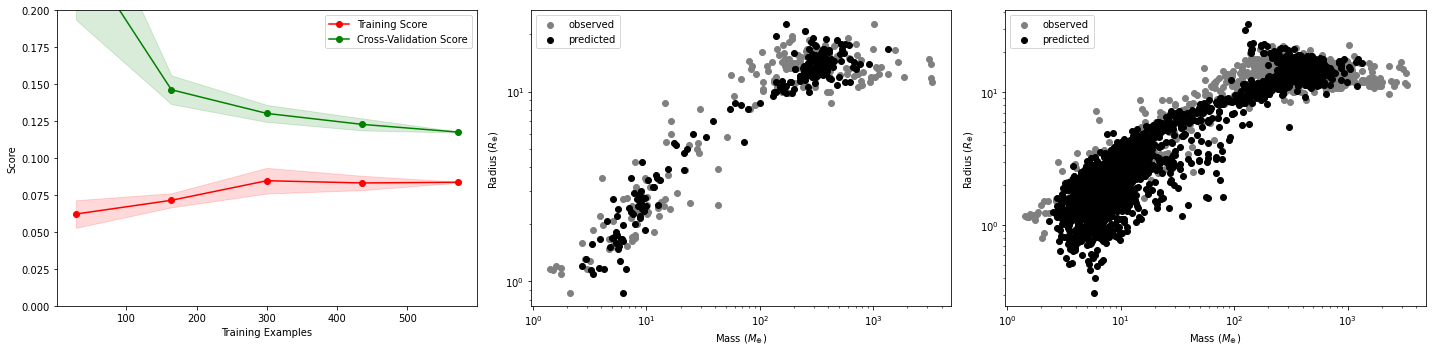

In [691]:
X_MR_ML_test = MR_ML_test.drop(columns = ['pl_bmasse', 'pl_bmasse_log'])
y_MR_ML_test = MR_ML_test['pl_bmasse']
y_MR_ML_test_log = MR_ML_test['pl_bmasse_log']


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

c = 0
model = final_trained_model_train_data_log_CVR
results = modified_learning_curve(X_log, y_log, X_MR_ML_test, y_MR_ML_test_log, model, N= 5, CV=5)

ax[c].set_xlabel("Training Examples")
ax[c].set_ylabel("Score")

ax[c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
ax[c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                results['mae_train_mean'] - results['mae_train_std'],
                alpha=0.15, color='r')

ax[c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
ax[c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                results['mae_test_mean'] - results['mae_test_std'],
                alpha=0.15, color='g')

ax[c].legend(loc="best")
ax[c].set_ylim(0.0,0.2)


y_predicted = np.power(10,model.predict(X_MR_ML_test))
ax[c+1].scatter(y_MR_ML_test, X_MR_ML_test['pl_rade'], color = 'grey',  label = 'observed')
ax[c+1].scatter(y_predicted, X_MR_ML_test['pl_rade'], color = 'black',  label = 'predicted')
ax[c+1].legend(loc = 'best')
ax[c+1].set_xscale('log')
ax[c+1].set_yscale('log')
ax[c+1].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+1].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')

M_pred = np.power(10,final_trained_model_train_data_log_CVR.predict(R_ML_table))
ax[c+2].scatter(MR_ML_table['pl_bmasse'], MR_ML_table['pl_rade'], color = 'grey',  label = 'observed')
ax[c+2].scatter( M_pred, R_ML_table['pl_rade'], color = 'black',  label = 'predicted')
ax[c+2].legend(loc = 'best')
ax[c+2].set_xscale('log')
ax[c+2].set_yscale('log')
ax[c+2].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+2].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')    
plt.tight_layout()

0.26735632804075793

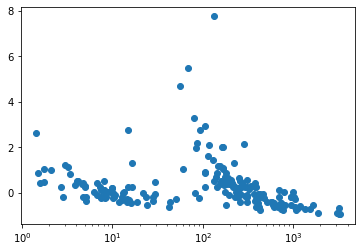

In [692]:
model = final_trained_model_train_data_log

y_predicted = np.power(10,model.predict(X_MR_ML_test))
y_test_linear = y_MR_ML_test

rel_mass = (y_predicted - y_test_linear)/y_test_linear

plt.scatter(y_test_linear, rel_mass)
plt.xscale('log')


np.mean(rel_mass)

In [693]:
best_model_log_RF, final_trained_model_train_data_log_RF  = RF_training_with_display_new(X_log,y_log, n_trials = 5, display = True, mae_type = 'dev_mae')

[I 2023-07-28 16:18:52,610] A new study created in memory with name: no-name-d41fd3dd-8e7b-436c-ad79-6c5f4803812a


The base MAE test =  0.09; MAE train = 0.01; MAE mean = 0.10


[I 2023-07-28 16:18:55,901] Trial 0 finished with value: 0.08533394740989993 and parameters: {'n_estimators': 40, 'min_samples_split': 39}. Best is trial 0 with value: 0.08533394740989993.
[I 2023-07-28 16:18:59,418] Trial 1 finished with value: 0.0866694336111244 and parameters: {'n_estimators': 60, 'min_samples_split': 50}. Best is trial 0 with value: 0.08533394740989993.
[I 2023-07-28 16:19:02,437] Trial 2 finished with value: 0.09597345005708988 and parameters: {'n_estimators': 100, 'min_samples_split': 43}. Best is trial 0 with value: 0.08533394740989993.
[I 2023-07-28 16:19:05,503] Trial 3 finished with value: 0.08336505264245175 and parameters: {'n_estimators': 100, 'min_samples_split': 24}. Best is trial 3 with value: 0.08336505264245175.
[I 2023-07-28 16:19:09,136] Trial 4 finished with value: 0.08677606309081917 and parameters: {'n_estimators': 100, 'min_samples_split': 44}. Best is trial 3 with value: 0.08336505264245175.



The best hyperparameters for RF Regressor: {'n_estimators': 100, 'min_samples_split': 24}


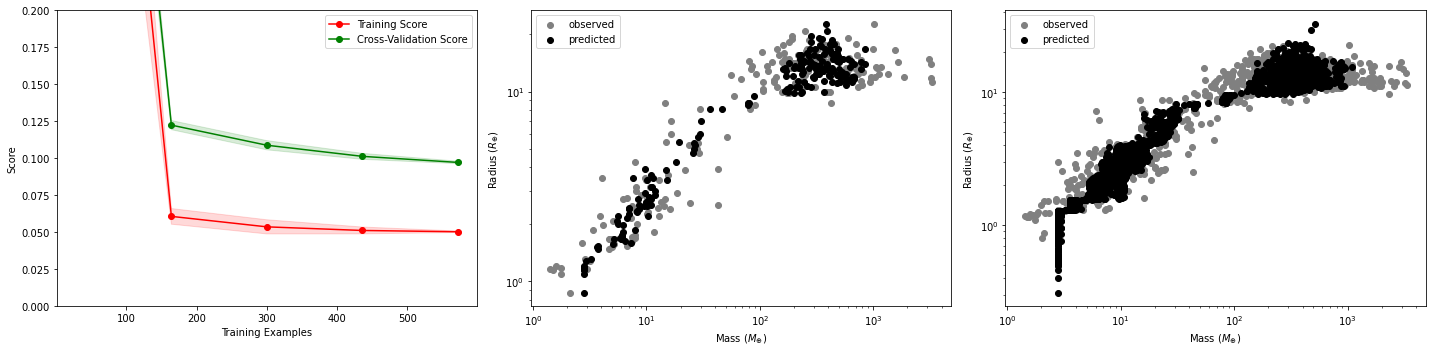

In [694]:
X_MR_ML_test = MR_ML_test.drop(columns = ['pl_bmasse', 'pl_bmasse_log'])
y_MR_ML_test = MR_ML_test['pl_bmasse']
y_MR_ML_test_log = MR_ML_test['pl_bmasse_log']


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

c = 0
model = final_trained_model_train_data_log_RF
results = modified_learning_curve(X_log, y_log, X_MR_ML_test, y_MR_ML_test_log, model, N= 5, CV=5)

ax[c].set_xlabel("Training Examples")
ax[c].set_ylabel("Score")

ax[c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
ax[c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                results['mae_train_mean'] - results['mae_train_std'],
                alpha=0.15, color='r')

ax[c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
ax[c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                results['mae_test_mean'] - results['mae_test_std'],
                alpha=0.15, color='g')

ax[c].legend(loc="best")
ax[c].set_ylim(0.0,0.2)


y_predicted = np.power(10,model.predict(X_MR_ML_test))
ax[c+1].scatter(y_MR_ML_test, X_MR_ML_test['pl_rade'], color = 'grey',  label = 'observed')
ax[c+1].scatter(y_predicted, X_MR_ML_test['pl_rade'], color = 'black',  label = 'predicted')
ax[c+1].legend(loc = 'best')
ax[c+1].set_xscale('log')
ax[c+1].set_yscale('log')
ax[c+1].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+1].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')

M_pred = np.power(10,final_trained_model_train_data_log_RF.predict(R_ML_table))
ax[c+2].scatter(MR_ML_table['pl_bmasse'], MR_ML_table['pl_rade'], color = 'grey',  label = 'observed')
ax[c+2].scatter( M_pred, R_ML_table['pl_rade'], color = 'black',  label = 'predicted')
ax[c+2].legend(loc = 'best')
ax[c+2].set_xscale('log')
ax[c+2].set_yscale('log')
ax[c+2].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+2].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')    
plt.tight_layout()

0.26735632804075793

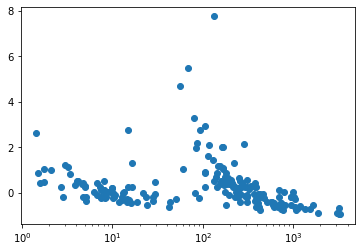

In [695]:
model = final_trained_model_train_data_log

y_predicted = np.power(10,model.predict(X_MR_ML_test))
y_test_linear = y_MR_ML_test

rel_mass = (y_predicted - y_test_linear)/y_test_linear

plt.scatter(y_test_linear, rel_mass)
plt.xscale('log')


np.mean(rel_mass)